In [1]:
import torch
from torch import nn
from torch.distributions import Poisson, Gamma, Normal
import matplotlib.pyplot as plt
import pytorch_lightning
import tqdm
import seaborn as sns

In [2]:
device = torch.device("cuda:5")
batch_size = 1024
val_batch_size = 30_000
training_iters = 5000
val_iters = 10
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [3]:
image_normalize_strategy = "linear_scale"

In [4]:
class ConstantLocsPrior:
    def __init__(self, low, high, offset):
        self.low = low
        self.high = high
        self.offset = offset

    def sample(self, sample_shape):
        mid_point = (self.low + self.high) / 2
        m = sample_shape[-1]
        mid_point = torch.stack([mid_point + self.offset * i for i in range(m)], dim=0)
        assert (mid_point <= self.high).all()
        return torch.ones(sample_shape[:-1]).unsqueeze(-1).unsqueeze(-1) * mid_point
    

class CatalogPrior:
    def __init__(
        self,
        num_objects: int,
        img_height: int,
        img_width: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
    ):
        self.num_objects = num_objects
        self.img_height = img_height
        self.img_width = img_width
        self.flux_prior = Gamma(torch.tensor(flux_alpha), 
                                torch.tensor(flux_beta))
        self.loc_prior = ConstantLocsPrior(torch.zeros(2), 
                                           torch.tensor((self.img_height, self.img_width)),
                                           offset=locs_offset)

    def sample(
        self,
        num_catalogs,
    ):
        fluxes = self.flux_prior.sample([num_catalogs, self.num_objects])  # (n_catalogs, m)
        locs = self.loc_prior.sample(
            [num_catalogs, self.num_objects]
        )  # (n_catalogs, m, 2)
        return {
            "count": torch.full((num_catalogs, ), fill_value=self.num_objects),
            "fluxes": fluxes, 
            "locs": locs
        }



class ImageSimulator(nn.Module):
    def __init__(
        self,
        img_height: int,
        img_width: int,
        num_objects: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
        psf_stdev: float,
        background_intensity: float,
    ):
        super().__init__()

        self.img_height = img_height
        self.img_width = img_width
        self.num_objects = num_objects

        self.psf_stdev = psf_stdev
        self.background_intensity = background_intensity

        self.catalog_prior = CatalogPrior(num_objects=num_objects,
                                          img_height=img_height,
                                          img_width=img_width,
                                          locs_offset=locs_offset,
                                          flux_alpha=flux_alpha,
                                          flux_beta=flux_beta)

        self.register_buffer("dummy_param", torch.zeros(0))
        self.register_buffer("psf_marginal_h",
                             (0.5 + torch.arange(self.img_height, dtype=torch.float32)).view(1, self.img_height, 1, 1))
        self.register_buffer("psf_marginal_w",
                             (0.5 + torch.arange(self.img_width, dtype=torch.float32)).view(1, 1, self.img_width, 1))

    @property
    def device(self):
        return self.dummy_param.device

    def psf(self, loc_h, loc_w):
        logpsf = -(
            (self.psf_marginal_h - loc_h.view(-1, 1, 1, self.num_objects)) ** 2
            + (self.psf_marginal_w - loc_w.view(-1, 1, 1, self.num_objects)) ** 2
        ) / (2 * self.psf_stdev ** 2)
        return torch.exp(logpsf - logpsf.logsumexp(dim=(1, 2), keepdim=True))
    
    def _generate(self, batch_size):
        tile_cat = self.catalog_prior.sample(num_catalogs=batch_size)
        tile_cat = {k: v.to(device=self.device) for k, v in tile_cat.items()}
        psf = self.psf(tile_cat["locs"][:, :, 0], tile_cat["locs"][:, :, 1])  # (b, h, w, m)
        source_intensities = (tile_cat["fluxes"].view(batch_size, 1, 1, self.num_objects) * psf).sum(dim=3)  # (b, h, w)
        total_intensities = source_intensities + self.background_intensity
        images = Poisson(total_intensities).sample()
        return {
            **tile_cat, 
            "psf": psf,
            "source_intensities": source_intensities,
            "total_intensities": total_intensities, 
            "images": images
        }
    
    def generate(self, batch_size, *, seed=None):
        if seed is not None:
            with torch.random.fork_rng(devices=["cpu", self.device]):
                torch.manual_seed(seed)
                output = self._generate(batch_size)
        else:
            output = self._generate(batch_size)
        return output

In [5]:
image_size = 4
num_objects = 1
background_intensity = 50.0
image_simulator = ImageSimulator(img_height=image_size, 
                                    img_width=image_size, 
                                    num_objects=num_objects, 
                                    locs_offset=0.5,
                                    flux_alpha=10.0,
                                    flux_beta=0.01,
                                    psf_stdev=1.0, 
                                    background_intensity=background_intensity).to(device=device)

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(image_size * image_size * num_objects, hidden_ch),
            nn.LayerNorm(hidden_ch),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.LayerNorm(hidden_ch),
                    nn.ReLU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 4)
        )
    
    def forward(self, image):
        x = image.flatten(start_dim=1)
        return self.network(x).chunk(2, dim=-1)
    
    def nll(self, image, true_fluxes):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return -1 * Normal(loc, scale.abs() + 1e-5).log_prob(true_fluxes)
    
    def sample(self, image, sample_size):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return Normal(loc, scale.abs() + 1e-5).sample(sample_size)

In [7]:
my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [8]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    return flux / max_flux_boundary

def decode_flux(flux: torch.Tensor):
    return flux * max_flux_boundary

In [9]:
my_net.train()
loss_record = []
shuffle_flux = lambda x: x[..., torch.randperm(x.shape[-1])]
shuffle_flux = torch.vmap(shuffle_flux, randomness="different")
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    target_fluxes = torch.cat([target_fluxes, torch.zeros_like(target_fluxes)], dim=-1)  # (b, 2)
    target_fluxes = shuffle_flux(target_fluxes)
    input_image = catalog["images"]  # (b, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    loss = my_net.nll(input_image, encode_flux(target_fluxes)).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 509/5000 [00:08<01:09, 64.91it/s]

[500/5000] loss: -1.994e-02


 20%|██        | 1013/5000 [00:15<00:59, 66.67it/s]

[1000/5000] loss: -9.784e-03


 30%|███       | 1510/5000 [00:23<00:53, 64.68it/s]

[1500/5000] loss: -9.157e-03


 40%|████      | 2007/5000 [00:32<00:58, 50.99it/s]

[2000/5000] loss: 1.270e-02


 50%|█████     | 2510/5000 [00:41<00:48, 50.89it/s]

[2500/5000] loss: -5.432e-03


 60%|██████    | 3013/5000 [00:49<00:30, 65.04it/s]

[3000/5000] loss: -2.629e-02


 70%|███████   | 3510/5000 [00:57<00:22, 65.36it/s]

[3500/5000] loss: -1.971e-02


 80%|████████  | 4007/5000 [01:04<00:15, 65.32it/s]

[4000/5000] loss: -1.745e-03


 90%|█████████ | 4508/5000 [01:14<00:09, 51.92it/s]

[4500/5000] loss: -1.977e-02


100%|██████████| 5000/5000 [01:23<00:00, 59.88it/s]

[5000/5000] loss: -3.108e-02


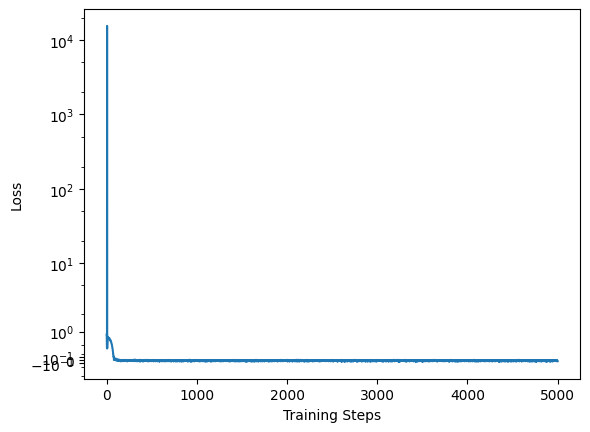

In [10]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("asinh")
plt.show()

In [11]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
    val_true_fluxes = target_fluxes
    input_image = val_catalog["images"]
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    sample = my_net.sample(input_image, sample_size=[val_iters]).squeeze(0)
    val_est_fluxes = decode_flux(sample).cpu()

In [12]:
val_est_fluxes.shape, val_true_fluxes.shape

(torch.Size([10, 30000, 2]), torch.Size([30000, 1]))

In [13]:
val_true_fluxes = torch.cat([val_true_fluxes, torch.zeros_like(val_true_fluxes)], dim=-1)
val_true_fluxes = shuffle_flux(val_true_fluxes)

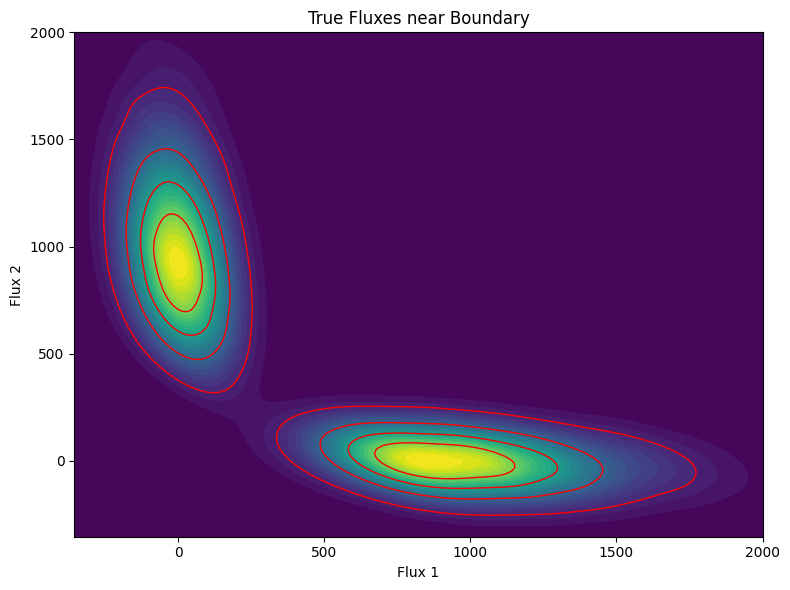

In [14]:
x = val_true_fluxes[..., 0].view(-1).cpu()
y = val_true_fluxes[..., 1].view(-1).cpu()
selected_indexes = torch.randperm(x.shape[0])[:10_000]
x = x[selected_indexes]
y = y[selected_indexes]
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=x, y=y,
    fill=True,
    levels=30,
    thresh=0.0,
    cmap="viridis"
)
sns.kdeplot(
    x=x, y=y,
    fill=False,
    levels=5,
    color="red",
    linewidths=1.0,
    thresh=1e-1,
)
plt.xlabel("Flux 1")
plt.ylabel("Flux 2")
plt.xlim(right=2000)
plt.ylim(top=2000)
plt.title("True Fluxes near Boundary")
plt.tight_layout()
plt.show()

In [15]:
val_est_fluxes.min(), val_est_fluxes.max()

(tensor(-2477.3091), tensor(4988.8770))

In [16]:
# val_est_fluxes = val_est_fluxes.clamp(min=0)

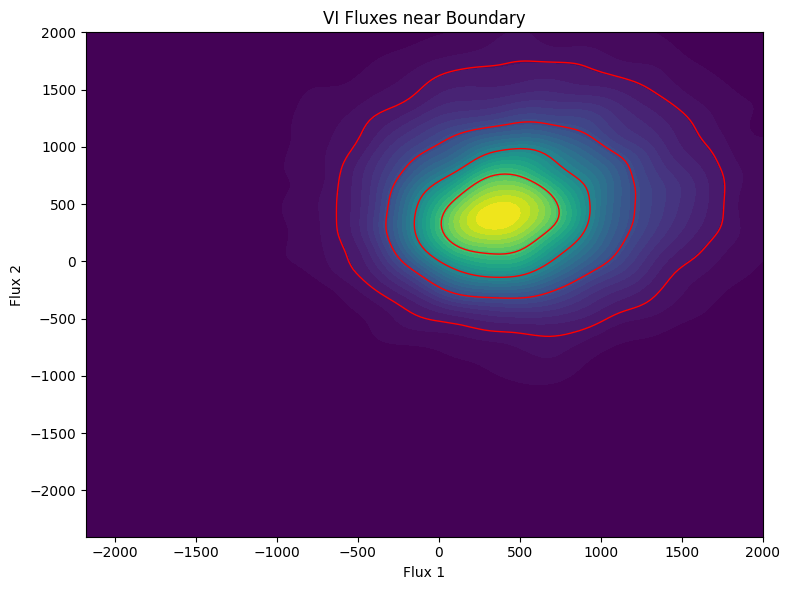

In [17]:
x = val_est_fluxes[..., 0].view(-1)
y = val_est_fluxes[..., 1].view(-1)
selected_indexes = torch.randperm(x.shape[0])[:10_000]
x = x[selected_indexes]
y = y[selected_indexes]
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=x, y=y,
    fill=True,
    levels=30,
    thresh=0.0,
    cmap="viridis"
)
sns.kdeplot(
    x=x, y=y,
    fill=False,
    levels=5,
    color="red",
    linewidths=1.0,
    thresh=1e-1,
)
plt.xlabel("Flux 1")
plt.ylabel("Flux 2")
plt.xlim(right=2000)
plt.ylim(top=2000)
plt.title("VI Fluxes near Boundary")
plt.tight_layout()
plt.show()